# Data Exploration

Let's explore the data scrapped from [e-newspapersarchives.ch](https://www.e-newspaperarchives.ch/?a=p&p=home&e=-------fr-20--1--txt-txIN-+e-------0--fr---).

Quick reminder before starting: `articles.csv` contains all articles found on the aforementionned website that contain the world "écologie" (accent sensitive). The file contains several informations about the retrieved articles:
- *Article Title*: the header of the article
- *Journal*: name of the newspaper in which it was published
- *Date*: date of publication (in french, format: DAY mois YEAR, eg. 10 septembre 1992)
- *Url*: url link to the article
- *Text*: OCR text from the article

In [1]:
# import basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# import package to parse date from str to datetime format
try:
    import dateparser
except:
    !pip install dateparser
    import dateparser

In [3]:
# store the dataset into a Pandas DataFrame and parse the date
articles = pd.read_csv("articles.csv", parse_dates=['Date'], date_parser=dateparser.parse)
n_before = len(articles) # number of articles in the DF
articles.sample(5)

,Unnamed: 0,Article Title,Journal,Date,Url,Text
2020,0,L'arrête est en quelque sorte une tranch...,Le Nouvelliste,1987-10-09,https://www.e-newspaperarchives.ch/?a=d&d=NVE1...,Larrête est en quelque sorte une tranche dun ...
105,5,Pire que prévu,Le Nouvelliste,2010-12-31,https://www.e-newspaperarchives.ch/?a=d&d=NVE2...,Pire que prévu ÉCOLOGIE Quelque 250 milli...
1789,9,ECOLE. Soirée d'information concernant l...,La Liberté,1992-11-05,https://www.e-newspaperarchives.ch/?a=d&d=LLE1...,ECOLE . Soirée dinformation concernant lEcole...
1762,2,Missionnaire fribourgeois en Bolivie,La Liberté,1998-07-15,https://www.e-newspaperarchives.ch/?a=d&d=LLE1...,Missionnaire fribourgeois en Bolivie ÉDITION...
671,11,Nucléaire: les VertEs contents mais... R...,La Liberté,1990-09-24,https://www.e-newspaperarchives.ch/?a=d&d=LLE1...,Nucléaire : les VertEs contents mais ... Reco...


In [4]:
# drop rows (=articles) with missing informations
articles = articles.dropna().reset_index()
print("{0} rows with NaN dropped, {1} articles remaining in the DF.".format(n_before-len(articles), len(articles)))

5 rows with NaN dropped, 2805 articles remaining in the DF.


## Distribution over time

Let's first look at the number of articles retrieved per year.

TODO:
- [ ] find the total number of articles per year on the website to normalize

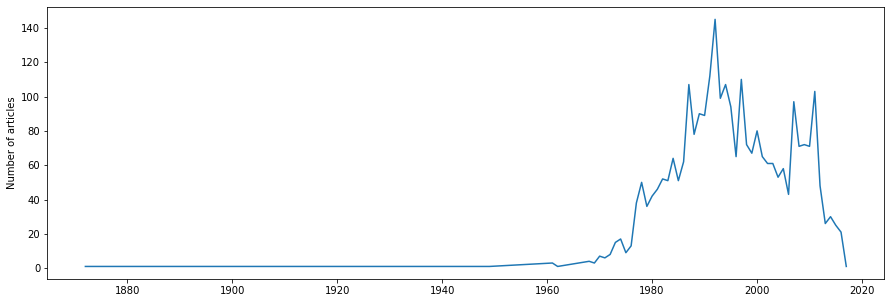

In [5]:
# number of articles per year
articles_per_year = articles.groupby(articles.Date.dt.year).count().Url

# plot the timeserie
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(articles_per_year)

plt.ylabel('Number of articles')

plt.show()

From the above plot, one can already see that this term began to be used in the late 60s/early 70s and peaked around 1990 and a second, less important, peak happened around 2010.

In [6]:
print("The year with the most articles containing 'écologie' is {0}, with {1} articles.\
".format(articles_per_year.keys()[articles_per_year == np.max(articles_per_year)][0], np.max(articles_per_year)))

The year with the most articles containing 'écologie' is 1992, with 145 articles.


In [7]:
print("Only {0} articles were found before 1960.".format(len(articles[articles.Date.dt.year<1970])))

Only 17 articles were found before 1960.


Grouping the articles by decade

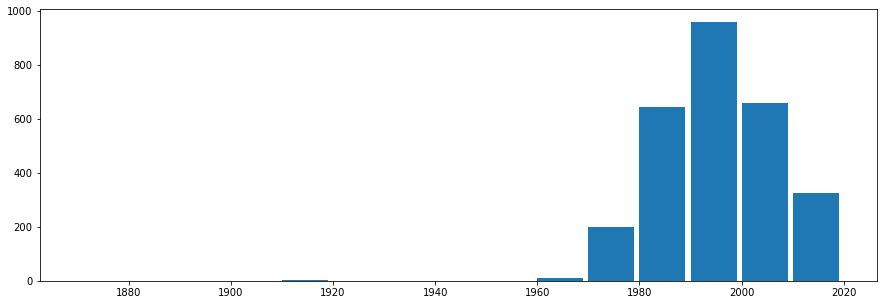

In [8]:
articles_per_decade = articles.groupby((articles.Date.dt.year//10)*10).count().Url

plt.figure(figsize=(15,5))
plt.bar(articles_per_decade.index
        , articles_per_decade
        , width=9
        , align='edge'
       )
plt.show()

Such a grouping makes the 2010's peak disappear as it was centered around 2010 (from late 2000s to early 2010s).

++ we can see a strange pattern by month (if significant?)

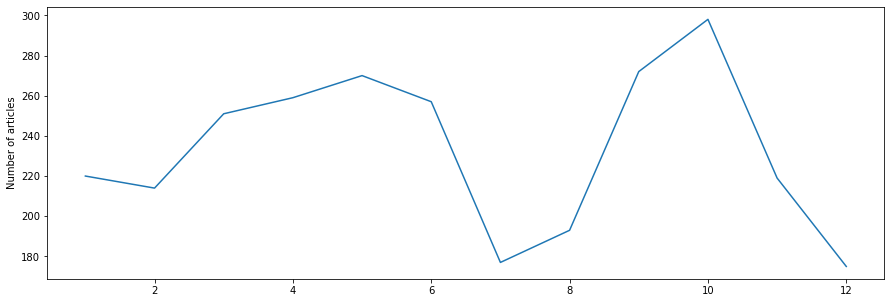

In [9]:
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(articles.groupby(articles.Date.dt.month).count().Url)

plt.ylabel('Number of articles')

plt.show()

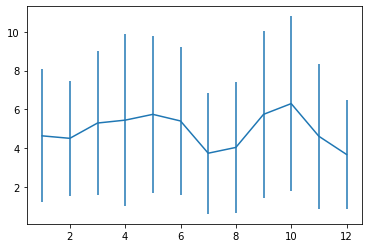

In [10]:
y_m_articles = articles[articles.Date.dt.year>1970].groupby([articles.Date.dt.year, articles.Date.dt.month]).count().Url
y_m_articles.index.set_names(["Year", "Month"], inplace=True)
mean_m_articles = y_m_articles.unstack().fillna(0).stack().reset_index().groupby('Month').mean()[0]
std_m_articles = y_m_articles.unstack().fillna(0).stack().reset_index().groupby('Month').std()[0]

plt.errorbar(mean_m_articles.index, mean_m_articles, yerr=std_m_articles)
plt.show()
# seems not really significant all in all

## Distribution over newspaper editors

Let's then study the diversity of the corpus in term of the distribution of the articles over different newspaper editors.

In [11]:
n_journaux = articles.groupby(articles.Journal).count().Url.sort_values()
print("The dataset contains articles from {0} editors.".format(len(n_journaux)))

The dataset contains articles from 23 editors.


Let's have a look at the number of articles per editor:

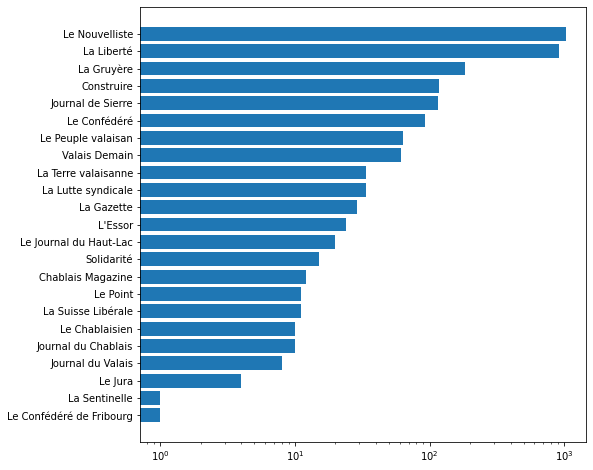

In [12]:
plt.figure(figsize=(8,8))
plt.barh(n_journaux.keys(), n_journaux)
plt.semilogx()
plt.show()

One can see from the above plot that the dataset is largely dominated by two editors, namely *Le Nouvelliste* and *La Liberté*.

In [13]:
print("The two most represented editors have published {0:.2f}% of all the articles present in the dataset.\
".format(100*(n_journaux[-1]+n_journaux[-2])/n_journaux.sum()))

The two most represented editors have published 69.52% of all the articles present in the dataset.


## Editors' time

Let's put both of the precedently studied features together now by exporing the evolution of the presence of the editors. As seen before, two editors are much more in the dataset, we will then rearrange the DF for this part of the exploration. Instead of the name of the newspaper, all articles that are not published in one of the two top editors will appear has published in *Others*.

In [14]:
top_editors = np.array(n_journaux.keys()[-2:])
articles_top_others = articles.copy()
articles_top_others["Journal"] = [j if j in top_editors else "Others" for j in articles_top_others["Journal"]]

In [15]:
# number of articles per journal per year
evol_year_top_others = articles_top_others[articles_top_others.Date.dt.year>1960].groupby([articles_top_others.Date.dt.year, "Journal"]).count().Url.unstack().fillna(0)
# normalization over the year (for each year --> sum to 1)
evol_year_top_others_norm = evol_year_top_others.div(evol_year_top_others.sum(axis=1), axis=0)

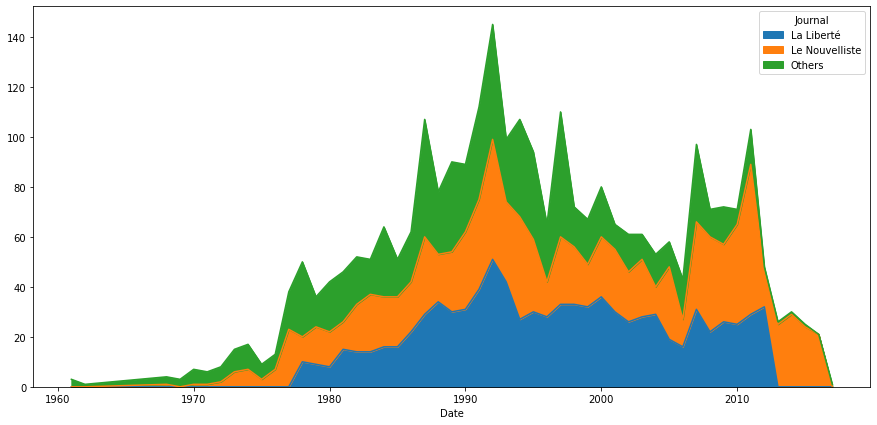

In [16]:
fig, axis = plt.subplots(figsize=(15,7))
ax = evol_year_top_others.plot.area(ax=axis)
plt.show()

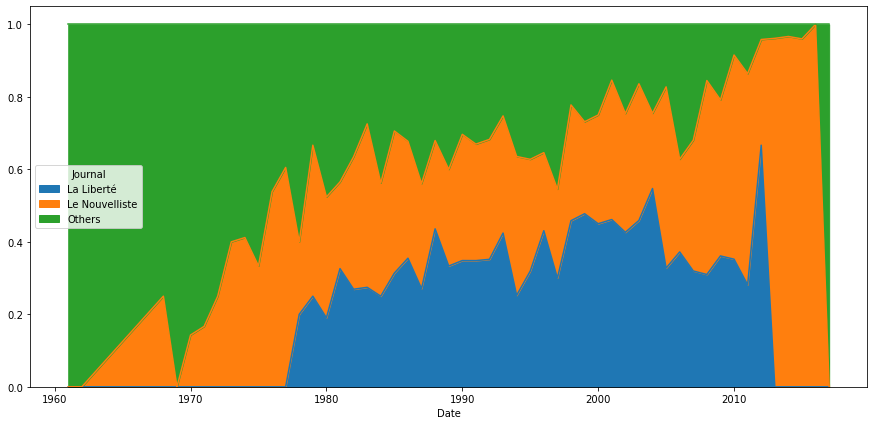

In [17]:
fig, axis = plt.subplots(figsize=(15,7))
ax = evol_year_top_others_norm.plot.area(ax=axis)
plt.show()

The same analysis can be lead on decades:

In [18]:
decade_top_others = articles_top_others[(articles_top_others.Date.dt.year//10)*10 >1955].groupby([(articles_top_others.Date.dt.year//10)*10, "Journal"]).count().Url.unstack().fillna(0)
decade_top_others

Journal,La Liberté,Le Nouvelliste,Others
Date,,,
1960,0.0,1.0,10.0
1970,19.0,75.0,105.0
1980,198.0,201.0,244.0
1990,346.0,298.0,316.0
2000,263.0,247.0,151.0
2010,86.0,213.0,26.0


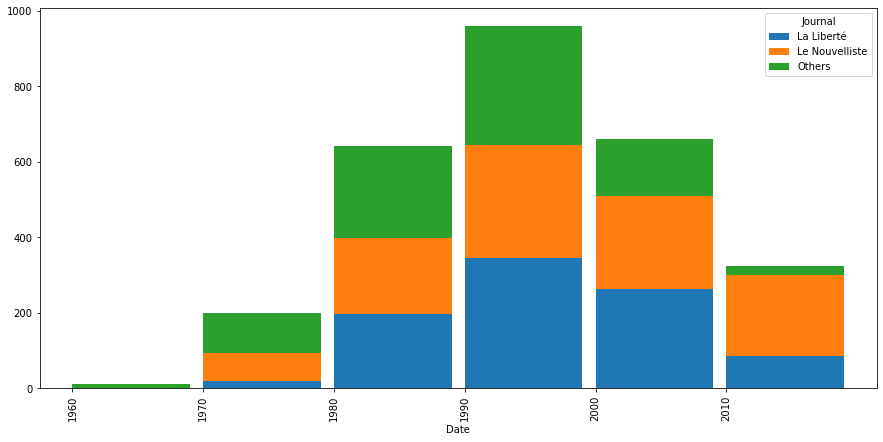

In [19]:
fig, axis = plt.subplots(figsize=(15,7))
decade_top_others.plot.bar(stacked=True, align='edge', ax=axis, width=0.9)
plt.show()

## What's in those articles ?

We can now try to see what the article contain.

We can begin by printing the content of a random article of the dataset:

In [20]:
# it is sometimes really weird
print(articles.iloc[np.int(np.random.random()*len(articles))].Text)

 DOUBLE PRIME SUR TOUTE LA GAMME CITROËN  NE CHOISISSEZ PAS ENTRE TECHNOLOGIE  ET  ÉCOLOGIE   de prime TECHNOLOGIQUE  de prime ÉCOLOGIQUE sur les modèles  *  Soit CITROËN C 5 TOURER 


Let's have a look at the distribution of the number of characters among all articles of the dataset:

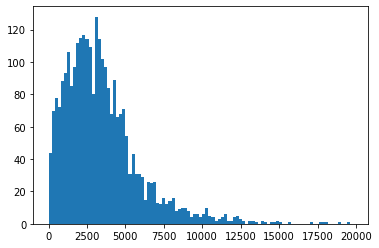

In [21]:
bins = np.arange(0, 20000, 200)
hist_nb_char, bin_edges, patches = plt.hist([len(articles.Text[i]) for i in range(len(articles))], bins=bins)